# Modelling 
## Strategie 1
For this time, we'll no try to predict the `global` target. Like we have seen in our EDA\
the high correlation between the averages and the feature involved the `home_team_goal` & `away_team_goal`.
- Target = **For classification problem we gonna cut in bins the goal team, it might be the scored goal or the conceded goal**
- Features = **goal averages for team at home and away before the current match**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
path = Path.cwd().parent.parent / 'data' / '2022_23' / 'results' / 'ligue1.csv'
df = pd.read_csv(path, parse_dates=True, index_col='date_time')
df.head()

,journée,home_team,away_team,1st_home_team_goal,1st_away_team_goal,1st_total_goal,2nd_home_team_goal,2nd_away_team_goal,2nd_total_goal,total_home_team_goal,total_away_team_goal,global
date_time,,,,,,,,,,,,
2023-06-03 19:00:00,38,AC Ajaccio,Marseille,0,0,0,1,0,1,1,0,1
2023-06-03 19:00:00,38,Nice,Lyon,3,1,4,0,0,0,3,1,4
2023-06-03 19:00:00,38,Troyes,Lille,0,0,0,1,1,2,1,1,2
2023-06-03 19:00:00,38,Reims,Montpellier,1,0,1,0,3,3,1,3,4
2023-06-03 19:00:00,38,PSG,Clermont,2,2,4,0,1,1,2,3,5


### Feature Engineering

In [3]:
def feature_engineering(df):
    """This function aims to create new features
    It will calculate for each team
    the average of goal scored and conceded before the current match
    """
    data = df.copy()
    data = data.sort_values(by='journée', ascending=True)
    data = data[['journée', 'home_team', 'away_team', 'total_home_team_goal',
                     'total_away_team_goal', 'global']]
    for row in data.iterrows():
        data['ht_scored_avg'] = data.groupby('home_team')['total_home_team_goal'].transform(lambda x: x.expanding().mean().shift())
        data['ht_conceded_avg'] = data.groupby('home_team')['total_away_team_goal'].transform(lambda x: x.expanding().mean().shift())
        data['at_scored_avg'] = data.groupby('away_team')['total_away_team_goal'].transform(lambda x: x.expanding().mean().shift())
        data['at_conceded_avg'] = data.groupby('away_team')['total_home_team_goal'].transform(lambda x: x.expanding().mean().shift())
    return data

In [4]:
transformed_df = feature_engineering(df)

In [5]:
transformed_df.tail()

,journée,home_team,away_team,total_home_team_goal,total_away_team_goal,global,ht_scored_avg,ht_conceded_avg,at_scored_avg,at_conceded_avg
date_time,,,,,,,,,,
2023-06-03 19:00:00,38,PSG,Clermont,2,3,5,2.388889,1.222222,1.222222,1.055556
2023-06-03 19:00:00,38,Reims,Montpellier,1,3,4,1.500000,1.111111,1.833333,1.777778
2023-06-03 19:00:00,38,Troyes,Lille,1,1,2,1.000000,1.611111,1.333333,1.000000
2023-06-03 19:00:00,38,Nice,Lyon,3,1,4,1.166667,0.944444,1.611111,1.388889
2023-06-03 19:00:00,38,AC Ajaccio,Marseille,1,0,1,0.500000,1.666667,1.777778,0.833333


In [6]:
# we gonna drop the missing values
data = transformed_df[transformed_df['journée']>2]

### Preprocessing

In [7]:
data['class'] = pd.cut(x=data['total_home_team_goal'], bins=[min(data['total_home_team_goal']), 1,
                                                    max(data['total_home_team_goal'])],
                                                    labels=['under 1.5','over 1.5'], include_lowest=True)

/tmp/ipykernel_8432/3637374460.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = pd.cut(x=data['total_home_team_goal'], bins=[min(data['total_home_team_goal']), 1,


In [8]:
data['class'].value_counts()

under 1.5    211
over 1.5     149
Name: class, dtype: int64

In [9]:
code = {
        'under 1.5': 0,
        'over 1.5': 1}
data['class'] = data['class'].map(code)

/tmp/ipykernel_8432/3834802729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'].map(code)


In [10]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import RidgeClassifier, LinearRegression

In [11]:
# X represent the feature used to make prediction
# y the target to predict
X = data[['ht_scored_avg', 'at_conceded_avg']]
y = data['class']
# We gonna split the data into train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [12]:
def evaluation(x_test, y_test, model):
    """Test our model on the test set
    and show some metrics to evaluate performance of the model
    """
    print(f"Final Score {model.__class__.__name__} : {model.score(x_test, y_test)}")
    print(confusion_matrix(y_test, model.predict(x_test)))
    print(classification_report(y_test, model.predict(x_test)))

    N, train_score, val_score = learning_curve(
        model, x_train, y_train, train_sizes= np.linspace(0.1, 1.0, 10), cv=5
    )

    plt.plot(N, train_score.mean(axis=1), label='train')
    plt.plot(N, val_score.mean(axis=1), label='validation')
    plt.xlabel('train size')
    plt.legend()
    plt.show()

In [14]:
from sklearn.linear_model import RidgeClassifier
ridge_pipeline = make_pipeline(StandardScaler(), RidgeClassifier())
ridge_pipeline.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgeclassifier', RidgeClassifier())])

Final Score Pipeline : 0.6666666666666666
[[60  5]
 [31 12]]
              precision    recall  f1-score   support

           0       0.66      0.92      0.77        65
           1       0.71      0.28      0.40        43

    accuracy                           0.67       108
   macro avg       0.68      0.60      0.58       108
weighted avg       0.68      0.67      0.62       108



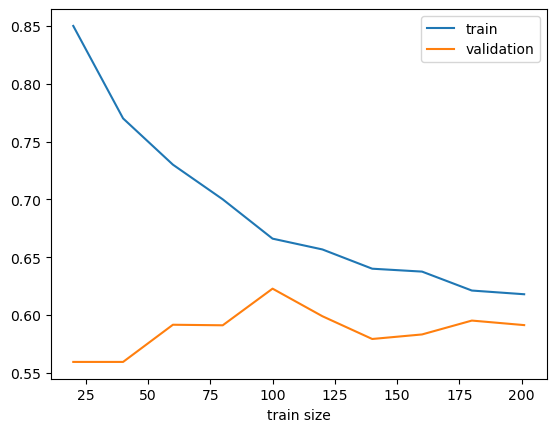

In [15]:
evaluation(x_test, y_test, model=ridge_pipeline)

### Interpretation
It seems like, our data does not represent well the problem, thus the score is pretty low cause we facing a underfitting issue. Though, the goal averages can serve later.

## Strategie 2
In football, there's something we call `tendance` which represent the form of the team, Thus we can observe for a time, a team scoring and winning much, but in a certain time the same team can lose all of their matchs.\
So if we want to predict the goal scored by the home team, we have to find the last five goal scored by the team and give them to our model

#### Feature Engineering 

In [16]:
data = df.copy()
data.sort_values(by='journée', ascending=True, inplace=True)
the_list = []
for i, row in data.iterrows():
    the_dict = {}
    last_values_home_team_scored = data[((data['home_team']== row['home_team']) | (data['away_team']== row['home_team'])) & (data['journée'] < row['journée'])]['total_home_team_goal'].tail().tolist()
    last_values_away_team_scored = data[((data['away_team']== row['away_team']) | (data['home_team']== row['away_team'])) & (data['journée'] < row['journée'])]['total_home_team_goal'].tail().to_list()
    the_dict['journée'], the_dict['home_team'], the_dict['away_team'], the_dict['home_team_goal'], the_dict['away_team_goal']\
     = row['journée'], row['home_team'], row['away_team'], row['total_home_team_goal'], row['total_away_team_goal']
    the_dict['lastValue_home_team_scored'] = last_values_home_team_scored
    the_dict['lastValue_away_team_scored'] = last_values_away_team_scored
    the_list.append(the_dict)
data = pd.DataFrame(the_list)

In [17]:
data.head(60)

,journée,home_team,away_team,home_team_goal,away_team_goal,lastValue_home_team_scored,lastValue_away_team_scored
0,1,Lyon,AC Ajaccio,2,1,[],[]
1,1,Marseille,Reims,4,1,[],[]
2,1,Rennes,Lorient,0,1,[],[]
3,1,Lille,Auxerre,4,1,[],[]
4,1,Angers,Nantes,0,0,[],[]
5,1,Strasbourg,Monaco,1,2,[],[]
6,1,Lens,Brest,3,2,[],[]
7,1,Toulouse,Nice,1,1,[],[]
8,1,Clermont,PSG,0,5,[],[]
9,1,Montpellier,Troyes,3,2,[],[]


In [18]:
data['home_team_goal_class'] = pd.cut(x=data['home_team_goal'], bins=[min(data['home_team_goal']), 1, max(
    data['home_team_goal'])], labels=['under 1.5', 'over 1.5'], include_lowest=True)
data['away_team_goal_class'] = pd.cut(x=data['away_team_goal'], bins=[min(data['away_team_goal']), 1, max(
    data['away_team_goal'])], labels=['under 1.5', 'over 1.5'], include_lowest=True)

In [19]:
def spread_list(data, col_prefix='lastValueN'):
    home_values = data['lastValue_home_team_scored']
    for i, value in enumerate(home_values):
        data[f"home_{col_prefix}{i+1}"] = value
    away_values = data['lastValue_away_team_scored']
    for i, value in enumerate(away_values):
        data[f"away_{col_prefix}{i+1}"] = value
    return data

data = data.apply(spread_list, axis=1)
short_data = data.drop(['lastValue_home_team_scored', 'lastValue_away_team_scored'], axis=1)

In [20]:
short_data = short_data[short_data['journée']>5]

In [21]:
short_data[['home_lastValueN1', 'home_lastValueN2', 'home_lastValueN3', 'home_lastValueN4', 'home_lastValueN5']] =\
short_data[['home_lastValueN1', 'home_lastValueN2', 'home_lastValueN3', 'home_lastValueN4', 'home_lastValueN5']].astype(int)

In [22]:
short_data['home_team_goal_class'].value_counts()

under 1.5    195
over 1.5     135
Name: home_team_goal_class, dtype: int64

In [23]:
code = {
        'under 1.5': 0,
        'over 1.5': 1}
short_data['home_team_goal_class'] = short_data['home_team_goal_class'].map(code)

In [24]:
short_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 50 to 379
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   away_lastValueN1      330 non-null    float64
 1   away_lastValueN2      330 non-null    float64
 2   away_lastValueN3      330 non-null    float64
 3   away_lastValueN4      330 non-null    float64
 4   away_lastValueN5      330 non-null    float64
 5   away_team             330 non-null    object 
 6   away_team_goal        330 non-null    int64  
 7   away_team_goal_class  330 non-null    object 
 8   home_lastValueN1      330 non-null    int64  
 9   home_lastValueN2      330 non-null    int64  
 10  home_lastValueN3      330 non-null    int64  
 11  home_lastValueN4      330 non-null    int64  
 12  home_lastValueN5      330 non-null    int64  
 13  home_team             330 non-null    object 
 14  home_team_goal        330 non-null    int64  
 15  home_team_goal_class  

In [48]:
X = short_data[['home_lastValueN1', 'home_lastValueN2', 'home_lastValueN3', 'home_lastValueN4', 'home_lastValueN5']]
y = short_data['home_team_goal_class']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [73]:
from sklearn.linear_model import RidgeClassifier
ridge_estimator = make_pipeline(MinMaxScaler(), RidgeClassifier())
ridge_estimator.fit(x_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier())])

Final Score Pipeline : 0.5656565656565656
[[55  1]
 [42  1]]
              precision    recall  f1-score   support

           0       0.57      0.98      0.72        56
           1       0.50      0.02      0.04        43

    accuracy                           0.57        99
   macro avg       0.53      0.50      0.38        99
weighted avg       0.54      0.57      0.43        99



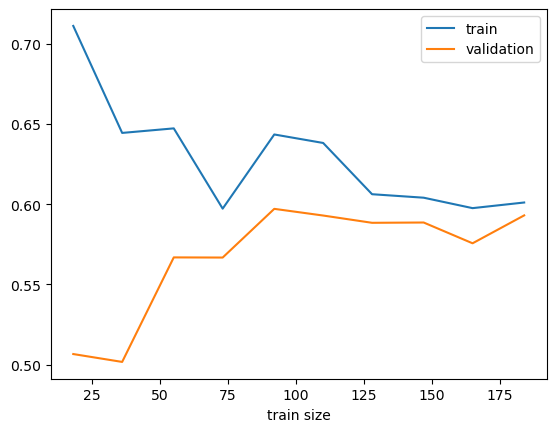

In [74]:
evaluation(x_test, y_test, model=ridge_estimator)

In [91]:
from sklearn.ensemble import RandomForestClassifier
rfc_estimator = make_pipeline(MinMaxScaler(), RandomForestClassifier())
rfc_estimator.fit(x_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

Final Score Pipeline : 0.6464646464646465
[[49  7]
 [28 15]]
              precision    recall  f1-score   support

           0       0.64      0.88      0.74        56
           1       0.68      0.35      0.46        43

    accuracy                           0.65        99
   macro avg       0.66      0.61      0.60        99
weighted avg       0.66      0.65      0.62        99



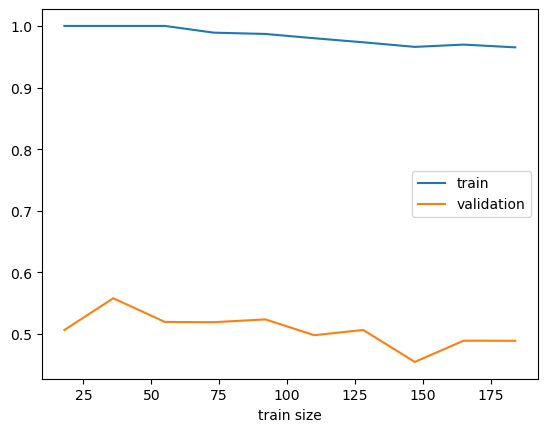

In [97]:
evaluation(x_test, y_test, model=rfc_estimator)

### Interpretation
We have seen that our different model are unable to predict with accuracy the `over 1.5` class

In [93]:
from sklearn.ensemble import VotingClassifier
clf1 = RidgeClassifier()
clf2 = RandomForestClassifier()
eclf = VotingClassifier(
    estimators=[('ridge', clf1), ('rfc', clf2)], voting='hard'
)
for clf, label in zip([clf1, clf2, eclf], ['Ridge Classifier', 'Random Forest Classifier', 'ensemble']):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.58 (+/- 0.03) [Ridge Classifier]
Accuracy: 0.49 (+/- 0.04) [Random Forest Classifier]
Accuracy: 0.56 (+/- 0.03) [ensemble]


In [96]:
from joblib import dump, load
dump(ridge_estimator, '../machine_learning/models/classifier/ridge_clf.joblib')
dump(ridge_estimator.named_steps['minmaxscaler'], '../machine_learning/models/classifier/minmaxscaler_ridge.joblib')

['../machine_learning/models/classifier/minmaxscaler_ridge.joblib']